In [149]:
import os
os.getcwd()

'/scratch/tfeng/codes/DrugCell'

In [3]:
# import anndata
import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.distributions import MultivariateNormal

import os
# os.environ["CUDA_VISIBLE_DEVICES"]="4"

import copy

import tqdm

In [4]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [5]:
from code.utils.util import *
from code.drugcell_NN import *

In [6]:
if torch.cuda.is_available():
  DEVICE = 'cuda'
else:
  DEVICE = 'cpu'

In [7]:
torch.cuda.device_count()

1

In [9]:
retrain = False

# Data Loading

## TCGA

In [10]:
class RNASeqData(Dataset):
    
    def __init__(self, X, c=None, y=None, transform=None):
        self.X = X
        self.y = y
        self.c = c
        self.transform = transform
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, index):
        sample = self.X[index,:]
        
        if self.transform is not None:
            sample = self.transform(sample)
        
        if self.y is not None and self.c is None:
            return sample, self.y[index]
        elif self.y is not None and self.c is not None:
            return sample, self.y[index], self.c[index]
        elif self.y is None and self.c is not None:
            return sample, self.c[index]
        else:
            return sample

In [11]:
## expression and IHC data

rna_seq = pd.read_csv('data/tcga/train_tcga_expression_matrix_processed.tsv',sep='\t',index_col=0)
# abeta_data = pd.read_csv('data/alzheimers-disease-gene-modules-master-data-preprocessed_data/data/preprocessed_data/All_Datasets_Abeta_IHC_Labels.tsv',index_col=0,sep='\t')

In [12]:
rna_seq.shape

(9954, 16148)

In [13]:
tcga_mad_genes = pd.read_csv('data/tcga/tcga_mad_genes.tsv', sep='\t')
tcga_sample_counts = pd.read_csv('data/tcga/tcga_sample_counts.tsv', sep='\t')

In [14]:
# rna_seq = rna_seq.loc[:,tcga_mad_genes.gene_id[:3000].apply(str)]
rna_seq = rna_seq / rna_seq.std()
rna_seq = np.log(rna_seq + 1)

In [15]:
rna_seq.shape

(9954, 16148)

In [16]:
tcga_sample_identifiers = pd.read_csv('data/tcga/tcga_sample_identifiers.tsv', sep='\t',index_col=0)

In [17]:
tcga_sample_identifiers

,sample_type,cancer_type
sample_id,,
TCGA-02-0047-01,Primary Solid Tumor,GBM
TCGA-02-0055-01,Primary Solid Tumor,GBM
TCGA-02-2483-01,Primary Solid Tumor,GBM
TCGA-02-2485-01,Primary Solid Tumor,GBM
TCGA-02-2486-01,Primary Solid Tumor,GBM
...,...,...
TCGA-ZS-A9CG-01,Primary Solid Tumor,LIHC
TCGA-ZT-A8OM-01,Primary Solid Tumor,THYM
TCGA-ZU-A8S4-01,Primary Solid Tumor,CHOL


In [18]:
# meta data labels 
# dataset_labels = pd.read_csv('data/alzheimers-disease-gene-modules-master-data-preprocessed_data/data/preprocessed_data/All_Dataset_Labels.tsv',index_col=0,sep='\t')
# region_labels = pd.read_csv('data/alzheimers-disease-gene-modules-master-data-preprocessed_data/data/preprocessed_data/All_Joined_Region_Labels.tsv',index_col=0,sep='\t')

### Transfer the entrezgene_id to hgnc_symbol

In [19]:
tcga_df = rna_seq

In [20]:
tcga_df.columns

Index(['1', '10', '100', '1000', '10000', '10001', '10002', '10003',
       '100037417', '10004',
       ...
       '9987', '9988', '9989', '999', '9990', '9991', '9992', '9993', '9994',
       '9997'],
      dtype='object', length=16148)

In [21]:
gene_id_dict = pd.read_csv('data/tcga/gene_dict.csv')

In [22]:
gene_id_dict[gene_id_dict.entrezgene_id == 213]

,hgnc_symbol,entrezgene_id,gene_biotype,description
3432,ALB,213,protein_coding,albumin [Source:HGNC Symbol;Acc:HGNC:399]


In [23]:
new_column = []
for col_name in tcga_df.columns:
    col_loc = (gene_id_dict.entrezgene_id == int(col_name))
    if np.sum(col_loc) == 0:
        tcga_df = tcga_df.drop(columns = col_name)
    else:
        new_column.append(gene_id_dict.hgnc_symbol[gene_id_dict.entrezgene_id == int(col_name)].iloc[0])

In [24]:
len(new_column)

16100

In [25]:
tcga_df.shape

(9954, 16100)

In [26]:
tcga_df.columns = new_column

## DCell

In [27]:
training_file = "data/drugcell_train.txt"
testing_file = "data/drugcell_test.txt"
val_file = "data/drugcell_val.txt"
cell2id_file = "data/cell2ind.txt"
drug2id_file = "data/drug2ind.txt"
genotype_file = "data/cell2mutation.txt"
fingerprint_file = "data/drug2fingerprint.txt"
onto_file = "data/drugcell_ont.txt"
gene2id_file = "data/gene2ind.txt"

train_data, feature_dict, cell2id_mapping, drug2id_mapping = prepare_train_data(training_file, 
                                                                  testing_file, cell2id_file, 
                                                                  drug2id_file)

gene2id_mapping = load_mapping(gene2id_file)

# load cell/drug features
cell_features = np.genfromtxt(genotype_file, delimiter=',')
drug_features = np.genfromtxt(fingerprint_file, delimiter=',')

num_cells = len(cell2id_mapping)
num_drugs = len(drug2id_mapping)
num_genes = len(gene2id_mapping)
drug_dim = len(drug_features[0,:])

# load ontology
dG, root, term_size_map, \
    term_direct_gene_map = load_ontology(onto_file, 
                                         gene2id_mapping)

Total number of cell lines = 1225
Total number of drugs = 684
There are 3008 genes
There are 1 roots: GO:0008150
There are 2086 terms
There are 1 connected componenets


## Find the intersection of TCGA and DCell genes

In [28]:
len(list(set(gene2id_mapping.keys()) & set(tcga_df.columns)))

2702

In [29]:
len(gene2id_mapping.keys())

3008

### Create gene2ID for tcga

In [30]:
tcga_gene2id = {}
for idx, gene in enumerate(tcga_df.columns):
    tcga_gene2id[gene] = idx

In [31]:
# num_genes = len(tcga_gene2id)
# # load ontology
# dG, root, term_size_map, \
#     term_direct_gene_map = load_ontology(onto_file, 
#                                          tcga_gene2id)

### Align gene id with tcga

In [32]:
gene_intersect_list = list(set(gene2id_mapping.keys()) & set(tcga_df.columns))
tcga_tensor = torch.zeros(tcga_df.shape[0], num_genes)

In [33]:
for gene in gene_intersect_list:
    idx = gene2id_mapping[gene]
    tcga_tensor[:,idx] = torch.tensor(tcga_df[gene])

(array([2.010e+02, 2.949e+03, 5.305e+03, 1.286e+03, 1.960e+02, 1.200e+01,
        2.000e+00, 1.000e+00, 0.000e+00, 2.000e+00]),
 array([0.12632112, 0.49959949, 0.8728779 , 1.24615622, 1.6194346 ,
        1.99271297, 2.36599135, 2.73926973, 3.11254811, 3.48582649,
        3.85910487]),
 <BarContainer object of 10 artists>)

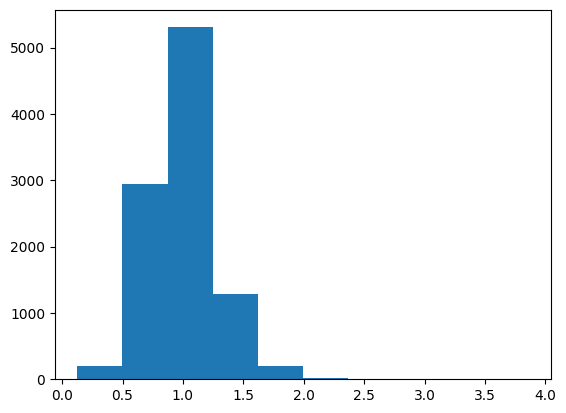

In [148]:
plt.hist(tcga_tensor[:,4])

In [141]:
cancer_type = tcga_sample_identifiers.loc[tcga_df.index, 'cancer_type']
cancer_type.value_counts()

BRCA    1096
KIRC     546
LUAD     519
THCA     513
UCEC     511
HNSC     510
LUSC     498
PRAD     495
LGG      477
COAD     446
SKCM     427
STAD     405
BLCA     384
LIHC     381
KIRP     290
CESC     279
OV       277
SARC     239
ESCA     177
PCPG     168
PAAD     165
LAML     156
GBM      155
READ     154
TGCT     140
THYM     110
KICH      81
MESO      78
UVM       72
ACC       71
UCS       51
DLBC      43
CHOL      40
Name: cancer_type, dtype: int64

In [36]:
cancer_2_idx = {}
idx_2_cancer = {}
cancer_type_idx = []

i = 0
for cancer in cancer_type:
    if cancer not in cancer_2_idx:
        cancer_2_idx[cancer] = i
        idx_2_cancer[i] = cancer
        cancer_type_idx.append(i)
        
        i += 1
    else:
        cancer_type_idx.append(cancer_2_idx[cancer])

In [37]:
y = torch.tensor(cancer_type_idx)

In [38]:
tcga_dataset = RNASeqData(X = tcga_tensor, y = y)
training_set, testing_set = random_split(tcga_dataset, [0.7, 0.3])

In [39]:
next(iter(training_set))

(tensor([0.0000, 0.4619, 1.1996,  ..., 0.1208, 1.2875, 0.6029]), tensor(10))

(array([1096.,  519.,   43.,  511.,  427.,  495.,  510.,  290.,  279.,
         513.,  546.,  405.,  446.,  154.,  477.,   78.,  156.,  384.,
         277.,  498.,   71.,  110.,  177.,  165.,  381.,  239.,  155.,
         140.,   81.,  168.,   51.,  112.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32.]),
 <BarContainer object of 32 artists>)

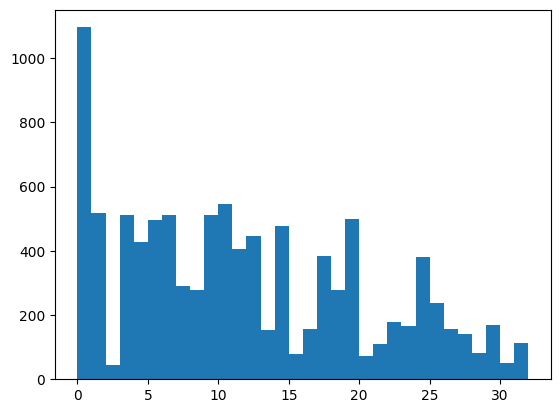

In [40]:
plt.hist(y, bins = 32)

In [41]:
cancer_2_idx

{'BRCA': 0,
 'LUAD': 1,
 'DLBC': 2,
 'UCEC': 3,
 'SKCM': 4,
 'PRAD': 5,
 'HNSC': 6,
 'KIRP': 7,
 'CESC': 8,
 'THCA': 9,
 'KIRC': 10,
 'STAD': 11,
 'COAD': 12,
 'READ': 13,
 'LGG': 14,
 'MESO': 15,
 'LAML': 16,
 'BLCA': 17,
 'OV': 18,
 'LUSC': 19,
 'ACC': 20,
 'THYM': 21,
 'ESCA': 22,
 'PAAD': 23,
 'LIHC': 24,
 'SARC': 25,
 'GBM': 26,
 'TGCT': 27,
 'KICH': 28,
 'PCPG': 29,
 'UCS': 30,
 'UVM': 31,
 'CHOL': 32}

# Model 

In [42]:
class dcell_vae(nn.Module):

    def __init__(self, term_size_map, term_direct_gene_map, dG, ngene, root, 
                 num_hiddens_genotype, num_hiddens_final, n_class, inter_loss_penalty = 0.2):

        super(dcell_vae, self).__init__()

        self.root = root
        self.num_hiddens_genotype = num_hiddens_genotype
        self.num_hiddens_final = num_hiddens_final
        self.n_class = n_class
        self.inter_loss_penalty = inter_loss_penalty
        self.dG = copy.deepcopy(dG)

        # dictionary from terms to genes directly annotated with the term
        self.term_direct_gene_map = term_direct_gene_map

        self.term_visit_count = {}
        self.init_term_visits(term_size_map)
        
        # calculate the number of values in a state (term): term_size_map is the number of all genes annotated with the term
        self.term_dim_map = {}
        self.cal_term_dim(term_size_map)

        # ngenes, gene_dim are the number of all genes
        self.gene_dim = ngene

        # add modules for neural networks to process genotypes
        self.contruct_direct_gene_layer()
        self.construct_NN_graph(self.dG)

        # add modules for final layer TODO: modify it into VAE
        final_input_size = num_hiddens_genotype # + num_hiddens_drug[-1]
        self.add_module('final_linear_layer', nn.Linear(final_input_size, num_hiddens_final * 2))
        self.add_module('final_batchnorm_layer', nn.BatchNorm1d(num_hiddens_final * 2))
        self.add_module('final_aux_linear_layer', nn.Linear(num_hiddens_final * 2, 1))
        self.add_module('final_linear_layer_output', nn.Linear(1, 1))
        
        self.decoder_affine = nn.Linear(num_hiddens_final, n_class)

    def init_term_visits(self, term_size_map):
        
        for term in term_size_map:
            self.term_visit_count[term] = 0
    
    # calculate the number of values in a state (term)
    def cal_term_dim(self, term_size_map):

        for term, term_size in term_size_map.items():
            num_output = self.num_hiddens_genotype

            # log the number of hidden variables per each term
            num_output = int(num_output)
#            print("term\t%s\tterm_size\t%d\tnum_hiddens\t%d" % (term, term_size, num_output))
            self.term_dim_map[term] = num_output


    # build a layer for forwarding gene that are directly annotated with the term
    def contruct_direct_gene_layer(self):

        for term, gene_set in self.term_direct_gene_map.items():
            if len(gene_set) == 0:
                print('There are no directed asscoiated genes for', term)
                sys.exit(1)

            # if there are some genes directly annotated with the term, add a layer taking in all genes and forwarding out only those genes
            self.add_module(term+'_direct_gene_layer', nn.Linear(self.gene_dim, len(gene_set)))

    # start from bottom (leaves), and start building a neural network using the given ontology
    # adding modules --- the modules are not connected yet
    def construct_NN_graph(self, dG):

        self.term_layer_list = []   # term_layer_list stores the built neural network
        self.term_neighbor_map = {}

        # term_neighbor_map records all children of each term
        for term in dG.nodes():
            self.term_neighbor_map[term] = []
            for child in dG.neighbors(term):
                self.term_neighbor_map[term].append(child)

        while True:
            leaves = [n for n in dG.nodes() if dG.out_degree(n) == 0]
            #leaves = [n for n,d in dG.out_degree().items() if d==0]
            #leaves = [n for n,d in dG.out_degree() if d==0]

            if len(leaves) == 0:
                break

            self.term_layer_list.append(leaves)

            for term in leaves:

                # input size will be #chilren + #genes directly annotated by the term
                input_size = 0

                for child in self.term_neighbor_map[term]:
                    input_size += self.term_dim_map[child]

                if term in self.term_direct_gene_map:
                    input_size += len(self.term_direct_gene_map[term])

                # term_hidden is the number of the hidden variables in each state
                term_hidden = self.term_dim_map[term]

                self.add_module(term+'_linear_layer', nn.Linear(input_size, term_hidden))
                self.add_module(term+'_batchnorm_layer', nn.BatchNorm1d(term_hidden))
                self.add_module(term+'_aux_linear_layer1', nn.Linear(term_hidden, self.n_class))
                self.add_module(term+'_aux_linear_layer2', nn.Linear(self.n_class, self.n_class))

            dG.remove_nodes_from(leaves)


    # definition of encoder
    def encoder(self, x):
        gene_input = x.narrow(1, 0, self.gene_dim)

        # define forward function for genotype dcell #############################################
        term_gene_out_map = {}

        for term, _ in self.term_direct_gene_map.items():
            term_gene_out_map[term] = self._modules[term + '_direct_gene_layer'](gene_input)

        term_NN_out_map = {}
        aux_out_map = {}

        for i, layer in enumerate(self.term_layer_list):

            for term in layer:

                child_input_list = []

                self.term_visit_count[term] += 1
                
                for child in self.term_neighbor_map[term]:
                    child_input_list.append(term_NN_out_map[child])

                if term in self.term_direct_gene_map:
                    child_input_list.append(term_gene_out_map[term])

                child_input = torch.cat(child_input_list,1)

                term_NN_out = self._modules[term+'_linear_layer'](child_input)

                Tanh_out = torch.tanh(term_NN_out)
                term_NN_out_map[term] = self._modules[term+'_batchnorm_layer'](Tanh_out)
                aux_layer1_out = torch.tanh(self._modules[term+'_aux_linear_layer1'](term_NN_out_map[term]))
                aux_out_map[term] = self._modules[term+'_aux_linear_layer2'](aux_layer1_out)

        # connect two neural networks at the top #################################################
        final_input = term_NN_out_map[self.root] # torch.cat((term_NN_out_map[self.root], drug_out), 1)

        out = self._modules['final_batchnorm_layer'](torch.tanh(self._modules['final_linear_layer'](final_input)))
        term_NN_out_map['final'] = out

        aux_layer_out = torch.tanh(self._modules['final_aux_linear_layer'](out))
        aux_out_map['final'] = self._modules['final_linear_layer_output'](aux_layer_out)

        return aux_out_map, term_NN_out_map
    
    def forward(self, x):
        
        aux_out_map, term_NN_out_map = self.encoder(x)
        
        mu = term_NN_out_map['final'][..., :self.num_hiddens_final]
        log_var = term_NN_out_map['final'][..., :self.num_hiddens_final]  # T X batch X z_dim
        std_dec = log_var.mul(0.5).exp_()
        # std_dec = 1
        
        latent = MultivariateNormal(loc = mu, 
                                    scale_tril=torch.diag_embed(std_dec))
        z = latent.rsample()
        
        recon_mean = self.decoder_affine(z)
        logits = F.softmax(recon_mean, -1)

        return logits, mu, log_var, aux_out_map, term_NN_out_map
    
    def loss_log_vae(self, logits, y, mu, log_var, beta = 0.001):
        # y: true labels
        ori_y_shape = y.shape
        
        class_loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), 
                                     y.reshape(-1), reduction = 'none').div(np.log(2)).view(*ori_y_shape)
        
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), 
                              dim = -1)
        
        log_loss = class_loss + beta * KLD
        log_loss = torch.mean(torch.logsumexp(log_loss, 0))
        
        return log_loss
    
    def intermediate_loss(self, aux_out_map, y):
        
        inter_loss = 0
        for name, output in aux_out_map.items():
            if name == 'final':
                inter_loss += 0
            else: # change 0.2 to smaller one for big terms
                ori_y_shape = y.shape
        
                term_loss = F.cross_entropy(output.view(-1, logits.shape[-1]), 
                                             y.reshape(-1), 
                                             reduction = 'none').div(np.log(2)).view(*ori_y_shape)
                inter_loss += term_loss

        return inter_loss

In [43]:
train_loader = DataLoader(training_set, batch_size=64, shuffle=False)
test_loader = DataLoader(testing_set, batch_size=64, shuffle=True)
(inputdata, labels) = next(iter(train_loader))


In [ ]:
# inputdata = inputdata

# # define forward function for genotype dcell #############################################
# term_gene_out_map = {}

# for term, _ in model.term_direct_gene_map.items():
#     term_gene_out_map[term] = model._modules[term + '_direct_gene_layer'](gene_input)

# term_NN_out_map = {}
# aux_out_map = {}

# for i, layer in enumerate(model.term_layer_list):

#     for term in layer:

#         child_input_list = []

#         model.term_visit_count[term] += 1
        
#         for child in model.term_neighbor_map[term]:
#             child_input_list.append(term_NN_out_map[child])

#         if term in model.term_direct_gene_map:
#             child_input_list.append(term_gene_out_map[term])

#         child_input = torch.cat(child_input_list,1)

#         term_NN_out = model._modules[term+'_linear_layer'](child_input)

#         Tanh_out = torch.tanh(term_NN_out)
#         term_NN_out_map[term] = model._modules[term+'_batchnorm_layer'](Tanh_out)
#         aux_layer1_out = torch.tanh(model._modules[term+'_aux_linear_layer1'](term_NN_out_map[term]))
#         aux_out_map[term] = model._modules[term+'_aux_linear_layer2'](aux_layer1_out)
#     break

In [ ]:
logits, mu, log_var, aux_out_map, term_NN_out_map = model(inputdata)

In [ ]:
term_NN_out_map['final'].shape

In [ ]:
dG.size()

In [ ]:
aux_out_map['GO:0007006'].shape

# Training

In [45]:
train_epochs = 200

train_loader = DataLoader(training_set, batch_size=64, shuffle=True)
test_loader = DataLoader(testing_set, batch_size=1024, shuffle=False)

In [46]:
num_hiddens_genotype = 6
num_hiddens_final = 6

model = dcell_vae(term_size_map, term_direct_gene_map, dG, num_genes, 
                 root, num_hiddens_genotype, num_hiddens_final, n_class = len(cancer_2_idx))

In [47]:
def create_term_mask(term_direct_gene_map, gene_dim, device):

    term_mask_map = {}

    for term, gene_set in term_direct_gene_map.items():

        mask = torch.zeros(len(gene_set), gene_dim)

        for i, gene_id in enumerate(gene_set):
            mask[i, gene_id] = 1

        mask_gpu = torch.autograd.Variable(mask)

        term_mask_map[term] = mask_gpu.to(device)

    return term_mask_map

term_mask_map = create_term_mask(model.term_direct_gene_map, num_genes, device = DEVICE)


In [ ]:
# model.to(DEVICE)
# learning_rate = 0.001
# torch.manual_seed(0)
# loss_list = []
# accu_list = []

# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.99), eps=1e-05)
# term_mask_map = create_term_mask(model.term_direct_gene_map, gene_dim=num_genes, device=DEVICE)

# optimizer.zero_grad()

# for name, param in model.named_parameters():
#     term_name = name.split('_')[0]

#     if '_direct_gene_layer.weight' in name:
#         param.data = torch.mul(param.data, term_mask_map[term_name].to(DEVICE)) * 0.1
#     else:
#         param.data = param.data * 0.1

# tepoch = tqdm.tqdm(range(train_epochs))
# for epoch in tepoch:
#     # Train
#     model.train()
#     train_predict = torch.zeros(0, 0).to(DEVICE)

#     for i, (data, labels) in enumerate(train_loader):
#         # Convert torch tensor to Variable

#         # Forward + Backward + Optimize
#         optimizer.zero_grad()  # zero the gradient buffer

#         # Here term_NN_out_map is a dictionary
#         logits, mu, log_var, aux_out_map, term_NN_out_map = model(data.to(DEVICE))

#         if train_predict.size()[0] == 0:
#             train_predict = aux_out_map["final"].data
#         else:
#             train_predict = torch.cat([train_predict, aux_out_map["final"].data], dim=0)

#         total_loss = 0

#         loss_vae = model.loss_log_vae(
#             logits=logits, y=labels.to(DEVICE), mu=mu, log_var=log_var, beta=0.001
#         )

#         loss_intermidiate = model.intermediate_loss(aux_out_map, labels.to(DEVICE))

#         total_loss = torch.mean(loss_vae + model.inter_loss_penalty * loss_intermidiate)
        
#         tmp_loss = total_loss.item()
        
#         total_loss.backward()

#         for name, param in model.named_parameters():
#             if "_direct_gene_layer.weight" not in name:
#                 continue
#             term_name = name.split("_")[0]
#             # print name, param.grad.data.size(), term_mask_map[term_name].size()
#             param.grad.data = torch.mul(param.grad.data, term_mask_map[term_name])

#         optimizer.step()
    
#     (inputdata, labels) = next(iter(test_loader))
#     logits, mu, log_var, aux_out_map, term_NN_out_map = model(inputdata.to(DEVICE))

#     accu = torch.sum(torch.argmax(logits, 1).cpu() == labels)/len(labels)
    
#     tepoch.set_postfix({"Epoch": epoch, "Loss": tmp_loss, "Accuracy": accu.item()})
    
#     loss_list.append(tmp_loss)
#     accu_list.append(accu.item())
#     # if epoch % 10 == 0:
#     torch.save(model, "model_200.pt")

In [113]:
# import pickle 

# with open('loss_accu.pkl', 'wb') as f:
#     pickle.dump({'loss': loss_list,
#                 'accu': accu_list}, f)

In [121]:
torch.argmax(logits, 1).cpu() 

tensor([ 1, 23, 24,  ...,  6, 14, 29])

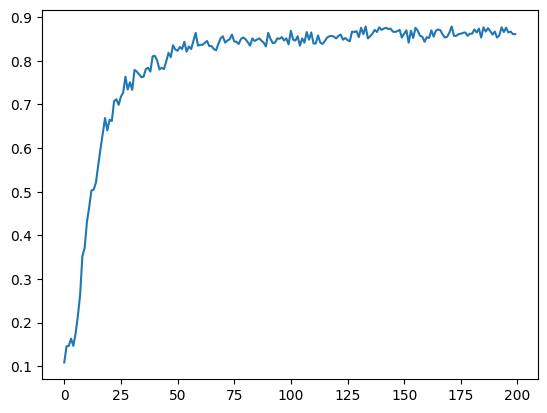

In [119]:
plt.plot(accu_list)

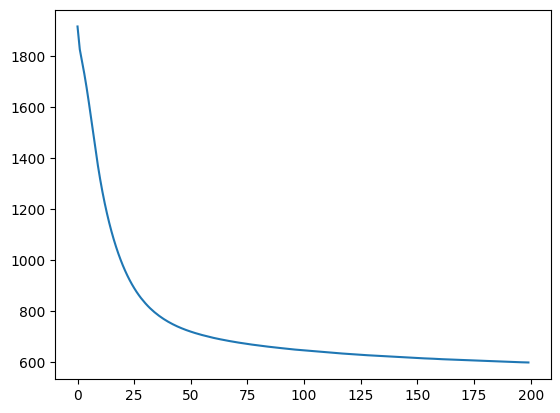

In [120]:
plt.plot(loss_list)

In [52]:
labels

tensor([21, 10,  6, 19, 16,  4,  0])

In [53]:
total_loss.shape

torch.Size([])

In [54]:
loss_vae

tensor(6.0861, device='cuda:0', grad_fn=<MeanBackward0>)

In [55]:
loss_intermidiate

tensor([2474.2014, 2002.4454, 1037.4922, 2438.5479, 3060.6013, 1722.8429,
        1948.4214], device='cuda:0', grad_fn=<AddBackward0>)

In [56]:
len(aux_out_map)

2087

In [57]:
torch.argmax(logits, 1)

tensor([21, 10,  6, 19, 15,  4,  0], device='cuda:0')

In [58]:
labels

tensor([21, 10,  6, 19, 16,  4,  0])

In [59]:
(inputdata, labels) = next(iter(test_loader))

In [60]:
logits, mu, log_var, aux_out_map, term_NN_out_map = model(inputdata.to(DEVICE))

In [61]:
torch.sum(torch.argmax(logits, 1).cpu() == labels)/len(labels)

tensor(0.6719)

In [62]:
labels

tensor([20,  5, 19, 17, 15,  5, 23, 10,  0, 18,  2,  6,  0,  5, 16, 15,  9, 13,
        21, 20, 10, 21,  9,  7,  0,  6, 20, 10,  6, 15, 14, 16,  9,  0, 15,  6,
         7,  8, 22,  4, 20, 19,  1,  0, 15, 20, 12,  3, 26, 27, 22, 26,  8, 19,
         5, 24, 19, 12, 19, 19,  6, 14,  6,  6])

In [63]:
torch.argmax(logits, 1).cpu()

tensor([20,  5, 21, 17, 15,  5, 21, 10,  2,  3,  6,  6,  0,  5, 13, 15,  9, 13,
        21, 20, 10, 21,  9, 19,  0,  6, 20, 10,  6, 15, 14,  8,  9,  0, 20,  6,
        10,  8,  9,  0,  4, 12,  0, 15, 15, 20, 12,  3, 11, 12, 22, 24,  8, 19,
         5,  4, 19, 12, 19,  5,  6, 14,  6,  6])

## Model Evaluation

In [66]:
test_loader = DataLoader(testing_set, batch_size=2986, shuffle=False)

In [48]:
model = torch.load("model_200.pt")
model.eval()

dcell_vae(
  (GO:0007005_direct_gene_layer): Linear(in_features=3008, out_features=32, bias=True)
  (GO:0006281_direct_gene_layer): Linear(in_features=3008, out_features=46, bias=True)
  (GO:0051052_direct_gene_layer): Linear(in_features=3008, out_features=18, bias=True)
  (GO:0000070_direct_gene_layer): Linear(in_features=3008, out_features=18, bias=True)
  (GO:1903047_direct_gene_layer): Linear(in_features=3008, out_features=45, bias=True)
  (GO:0022618_direct_gene_layer): Linear(in_features=3008, out_features=21, bias=True)
  (GO:0006631_direct_gene_layer): Linear(in_features=3008, out_features=50, bias=True)
  (GO:0000038_direct_gene_layer): Linear(in_features=3008, out_features=10, bias=True)
  (GO:0030001_direct_gene_layer): Linear(in_features=3008, out_features=194, bias=True)
  (GO:0070925_direct_gene_layer): Linear(in_features=3008, out_features=45, bias=True)
  (GO:1901566_direct_gene_layer): Linear(in_features=3008, out_features=165, bias=True)
  (GO:0043604_direct_gene_laye

In [67]:
(inputdata, labels) = next(iter(test_loader))

In [68]:
logits, mu, log_var, aux_out_map, term_NN_out_map = model(inputdata.to(DEVICE))

In [69]:
torch.sum(torch.argmax(logits, 1).cpu() == labels)/len(labels)

tensor(0.8774)

### Classifiaction accuracy of ontology processes

In [82]:
term_accu_dict = {}

for name, output in aux_out_map.items():
    if name == 'final':
        continue
    else: # change 0.2 to smaller one for big terms
        ori_y_shape = labels.shape

        term_accu_dict[name] = (torch.sum(torch.argmax(output, 1).cpu() == labels)/len(labels)).item()


In [96]:
sorted(term_accu_dict, key=term_accu_dict.get)[:5]

['GO:0006418', 'GO:0043038', 'GO:0052695', 'GO:0050913', 'GO:0050912']

(array([  3.,   2.,   3.,  51., 279., 511., 353., 234., 342., 308.]),
 array([0.16309445, 0.23874749, 0.31440054, 0.39005359, 0.46570664,
        0.54135969, 0.61701273, 0.69266578, 0.76831883, 0.84397188,
        0.91962492]),
 <BarContainer object of 10 artists>)

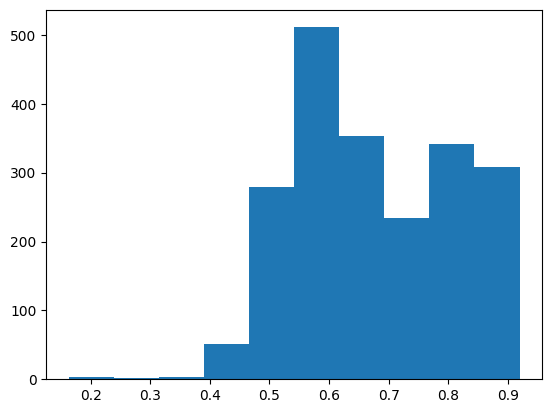

In [95]:
plt.hist(term_accu_dict.values())

### Classification accuracy per cancer type

In [100]:
labels[labels == 21]

tensor([21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
        21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21])

In [111]:
pred_res = torch.argmax(logits, 1).cpu() == labels

In [128]:
accu_per_type = {}

for cancer_type in range(33):
    accu_per_type[idx_2_cancer[cancer_type]] = (pred_res[labels == cancer_type]).float().mean().item()

In [129]:
accu_per_type

{'BRCA': 0.98591548204422,
 'LUAD': 0.729411780834198,
 'DLBC': 0.0,
 'UCEC': 0.9726027250289917,
 'SKCM': 0.9666666388511658,
 'PRAD': 1.0,
 'HNSC': 0.9929577708244324,
 'KIRP': 0.9275362491607666,
 'CESC': 0.0,
 'THCA': 0.9929078221321106,
 'KIRC': 0.959770143032074,
 'STAD': 0.9629629850387573,
 'COAD': 1.0,
 'READ': 0.0,
 'LGG': 0.9937106966972351,
 'MESO': 0.0,
 'LAML': 1.0,
 'BLCA': 0.8965517282485962,
 'OV': 1.0,
 'LUSC': 0.9873417615890503,
 'ACC': 0.0,
 'THYM': 1.0,
 'ESCA': 0.7755101919174194,
 'PAAD': 0.949999988079071,
 'LIHC': 1.0,
 'SARC': 0.953125,
 'GBM': 1.0,
 'TGCT': 1.0,
 'KICH': 0.0,
 'PCPG': 0.9791666865348816,
 'UCS': 0.0,
 'UVM': 0.0,
 'CHOL': 0.0}

In [150]:
pd.DataFrame([list(accu_per_type.keys()) , list(accu_per_type.values()), torch.bincount(labels).tolist()]).T.sort_values(by=1)

,0,1,2
32,CHOL,0.0,15
31,UVM,0.0,18
15,MESO,0.0,21
13,READ,0.0,46
8,CESC,0.0,84
28,KICH,0.0,26
2,DLBC,0.0,11
30,UCS,0.0,17
20,ACC,0.0,18
1,LUAD,0.729412,170


In [152]:
cancer_2_idx['LUAD']

1

In [156]:
(torch.argmax(logits, 1).cpu()[labels == 8])

tensor([ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  6,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3, 18,  3,  3,  3,  3,  3, 18,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3])

In [155]:
idx_2_cancer[19]

'LUSC'

### TNSE for latent embedding mean

In [157]:
from sklearn.manifold import TSNE

In [158]:
encoder_out = model.encoder(inputdata.to(DEVICE))